# Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
- train.csv
- test.csv

**Задание: Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели предсказать цены для квартир из файла test.csv.**

**Целевая переменная**: Price

Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

**Сдача проекта**:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price). В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

**Сроки и условия сдачи**:
- Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
- Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
- При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
- Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
- Успешный проект нельзя пересдать в целях повышения результата.
- Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
- В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

*Примечание*: Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

**Рекомендации для файла с кодом (ipynb)**:
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение библиотек Python и моделей машинного обучения,
которые были в курсе Python для Data Science. Градиентный бустинг изучается
в последующих курсах, поэтому в этом проекте его применять не следует.
Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [47]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use(['dark_background']) # тёмный фон графиков

In [48]:
train_dataset = '../../data/house_price/train.csv'
prepared_train_dataset = '../../data/house_price/train_prepared.csv'
df = pd.read_csv(train_dataset)
print(df.shape)
df.head()

(10000, 20)


Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038          35    2.0  47.981561   29.442751            6.0      7   
1  15053          41    3.0  65.683640   40.049543            8.0      7   
2   4765          53    2.0  44.947953   29.197612            0.0      8   
3   5809          58    2.0  53.352981   52.731512            9.0      8   
4  10783          99    1.0  39.649192   23.776169            7.0     11   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0         9.0       1969   0.089040         B         B        33      7976   
1         9.0       1978   0.000070         B         B        46     10309   
2        12.0       1968   0.049637         B         B        34      7759   
3        17.0       1977   0.437885         B         B        23      5735   
4        12.0       1976   0.012339         B         B        35      5776   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2          Price  
0         5           NaN            0       11       B  184966.930730  
1         1         240.0            1       16       B  300009.450063  
2         0         229.0            1        3       B  220925.908524  
3         3        1084.0            0        5       B  175616.227217  
4         1        2078.0            2        4       B  150226.531644

In [49]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 4)) + "\n" + "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))) 
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=pred_values, y=true_values, s=1)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

In [50]:
df.describe()

Id    DistrictId         Rooms        Square   LifeSquare  \
count  10000.00000  10000.000000  10000.000000  10000.000000  7887.000000   
mean    8383.40770     50.400800      1.890500     56.315775    37.199645   
std     4859.01902     43.587592      0.839512     21.058732    86.241209   
min        0.00000      0.000000      0.000000      1.136859     0.370619   
25%     4169.50000     20.000000      1.000000     41.774881    22.769832   
50%     8394.50000     36.000000      2.000000     52.513310    32.781260   
75%    12592.50000     75.000000      2.000000     65.900625    45.128803   
max    16798.00000    209.000000     19.000000    641.065193  7480.592129   

       KitchenSquare         Floor    HouseFloor     HouseYear     Ecology_1  \
count   10000.000000  10000.000000  10000.000000  1.000000e+04  10000.000000   
mean        6.273300      8.526700     12.609400  3.990166e+03      0.118858   
std        28.560917      5.241148      6.775974  2.005003e+05      0.119025   
min         0.000000      1.000000      0.000000  1.910000e+03      0.000000   
25%         1.000000      4.000000      9.000000  1.974000e+03      0.017647   
50%         6.000000      7.000000     13.000000  1.977000e+03      0.075424   
75%         9.000000     12.000000     17.000000  2.001000e+03      0.195781   
max      2014.000000     42.000000    117.000000  2.005201e+07      0.521867   

           Social_1      Social_2      Social_3  Healthcare_1   Helthcare_2  \
count  10000.000000  10000.000000  10000.000000   5202.000000  10000.000000   
mean      24.687000   5352.157400      8.039200   1142.904460      1.319500   
std       17.532614   4006.799803     23.831875   1021.517264      1.493601   
min        0.000000    168.000000      0.000000      0.000000      0.000000   
25%        6.000000   1564.000000      0.000000    350.000000      0.000000   
50%       25.000000   5285.000000      2.000000    900.000000      1.000000   
75%       36.000000   7227.000000      5.000000   1548.000000      2.000000   
max       74.000000  19083.000000    141.000000   4849.000000      6.000000   

            Shops_1          Price  
count  10000.000000   10000.000000  
mean       4.231300  214138.857399  
std        4.806341   92872.293865  
min        0.000000   59174.778028  
25%        1.000000  153872.633942  
50%        3.000000  192269.644879  
75%        6.000000  249135.462171  
max       23.000000  633233.466570

Проверка пропусков и типов данных. Какие данные не числовые.

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Обзор количественных переменных

In [52]:
df.isna().sum(axis = 0)

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

### Просмотр номинативных переменных

In [61]:
pd.concat([df['Ecology_2'].value_counts(), df['Ecology_3'].value_counts(), df['Shops_2'].value_counts()], axis=1)

Ecology_2 Ecology_3 Shops_2
0         B         B       B
1         B         B       B
2         B         B       B
3         B         B       B
4         B         B       B

In [62]:
df_obj_features = df.select_dtypes(include='object')
df_obj_features.head()

Ecology_2 Ecology_3 Shops_2
0         B         B       B
1         B         B       B
2         B         B       B
3         B         B       B
4         B         B       B

### Приведение категориальных переменных к dummy-переменным

In [7]:
df = pd.get_dummies(df)
df

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0     14038          35    2.0  47.981561   29.442751            6.0      7   
1     15053          41    3.0  65.683640   40.049543            8.0      7   
2      4765          53    2.0  44.947953   29.197612            0.0      8   
3      5809          58    2.0  53.352981   52.731512            9.0      8   
4     10783          99    1.0  39.649192   23.776169            7.0     11   
...     ...         ...    ...        ...         ...            ...    ...   
9995     77          32    2.0  50.401785   30.476203            5.0      6   
9996   6159          18    1.0  41.521546   20.539216            9.0     13   
9997   5123          27    1.0  47.939008         NaN            1.0     12   
9998   5400          75    2.0  43.602562   33.840147            8.0      1   
9999   6306         128    1.0  38.666645   21.157874            8.0      7   

      HouseFloor  HouseYear  Ecology_1  ...  Healthcare_1  Helthcare_2  \
0            9.0       1969   0.089040  ...           NaN            0   
1            9.0       1978   0.000070  ...         240.0            1   
2           12.0       1968   0.049637  ...         229.0            1   
3           17.0       1977   0.437885  ...        1084.0            0   
4           12.0       1976   0.012339  ...        2078.0            2   
...          ...        ...        ...  ...           ...          ...   
9995         5.0       1968   0.135650  ...         350.0            3   
9996        13.0       2000   0.000000  ...           NaN            0   
9997        16.0       2015   0.072158  ...           NaN            0   
9998         5.0       1961   0.307467  ...         325.0            2   
9999        17.0       1990   0.000000  ...          30.0            2   

      Shops_1          Price  Ecology_2_A  Ecology_2_B  Ecology_3_A  \
0          11  184966.930730            0            1            0   
1          16  300009.450063            0            1            0   
2           3  220925.908524            0            1            0   
3           5  175616.227217            0            1            0   
4           4  150226.531644            0            1            0   
...       ...            ...          ...          ...          ...   
9995       11  196684.316040            0            1            0   
9996        5  189050.289571            0            1            0   
9997        0  159143.805370            0            1            0   
9998        5  181595.339808            0            1            1   
9999        8  218714.077615            0            1            0   

      Ecology_3_B  Shops_2_A  Shops_2_B  
0               1          0          1  
1               1          0          1  
2               1          0          1  
3               1          0          1  
4               1          0          1  
...           ...        ...        ...  
9995            1          0          1  
9996            1          1          0  
9997            1          1          0  
9998            0          0          1  
9999            1          0          1  

[10000 rows x 23 columns]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Social_1       10000 non-null  int64  
 11  Social_2       10000 non-null  int64  
 12  Social_3       10000 non-null  int64  
 13  Healthcare_1   5202 non-null   float64
 14  Helthcare_2    10000 non-null  int64  
 15  Shops_1        10000 non-null  int64  
 16  Price          10000 non-null  float64
 17  Ecology_2_A    10000 non-null  uint8  
 18  Ecology

In [9]:
df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Price               0
Ecology_2_A         0
Ecology_2_B         0
Ecology_3_A         0
Ecology_3_B         0
Shops_2_A           0
Shops_2_B           0
dtype: int64

# Простая модель линейной регрессии

## Удалены данные с пропусками: LifeSquare, Healthcare_1
- R2:	0.4743
- MAE:	45456.504
- MSE:	4592242852.622

In [10]:
df_1 = df.drop(['LifeSquare', 'Healthcare_1'], axis=1)

In [11]:
y_1 = df_1['Price']
x_1 = df_1.drop('Price', axis=1)

x_train_1, x_valid_1, y_train_1, y_valid_1 = train_test_split(x_1, y_1, test_size=0.25)

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train_1, y_train_1)
y_pred = lr.predict(x_valid_1)

# Для подсчёта правильных ответов будем использовать метрику accuracy (_точность_). Она равна отношению числа объектов, на которых целевой класс был угадан верно, к общему числу объектов.
from sklearn.metrics import mean_squared_error
mse_train = mean_squared_error(y_pred, y_valid_1)
print(mse_train)

# Также сделаем предсказание на тренировочном датасете и посчитаем точность на нём:
y_pred_train_1 = lr.predict(x_train_1)
mse_test = mean_squared_error(y_pred_train_1, y_train_1)
print(mse_test)

4592242852.621778
4369480729.1713085


$R^2$

In [39]:
from sklearn.metrics import r2_score
r2_score_train = r2_score(y_valid_1, y_pred)
print(r2_score_train)
r2_score_test = r2_score(y_train_1, y_pred_train_1)
print(r2_score_test)

0.4742961423092533
0.49116996673560254


In [14]:
check_test = pd.DataFrame({'y_test_1': y_valid_1.round(), 'y_pred': y_pred.round()})
check_test.head(10)

y_test_1    y_pred
5135  165494.0  144678.0
3412  143180.0  198891.0
1510  223960.0  286961.0
1343  160869.0  172704.0
8212  212209.0  206207.0
3277  253984.0  294624.0
1084  203276.0  169408.0
7787   63677.0   97940.0
4962  201997.0  265275.0
843   466573.0  350540.0

R2:	0.4743
MAE:	45456.504
MSE:	4592242852.622


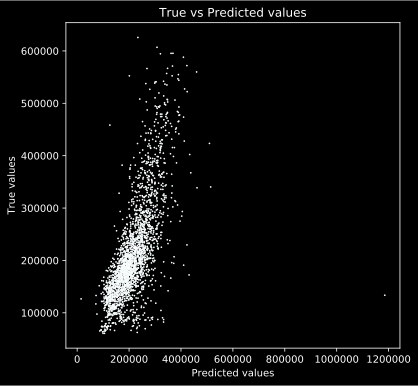

In [41]:
evaluate_preds(y_valid_1.values.flatten(), y_pred.flatten())

## Пропуски заменены на среднее значение

In [70]:
df2 = df
df2.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df2['LifeSquare']. median()

df2.isna().sum()
df2.describe()

Id    DistrictId         Rooms        Square    LifeSquare  \
count  10000.00000  10000.000000  10000.000000  10000.000000  10000.000000   
mean    8383.40770     50.400800      1.890500     56.315775     36.266040   
std     4859.01902     43.587592      0.839512     21.058732     76.609981   
min        0.00000      0.000000      0.000000      1.136859      0.370619   
25%     4169.50000     20.000000      1.000000     41.774881     25.527399   
50%     8394.50000     36.000000      2.000000     52.513310     32.781260   
75%    12592.50000     75.000000      2.000000     65.900625     41.427234   
max    16798.00000    209.000000     19.000000    641.065193   7480.592129   

       KitchenSquare         Floor    HouseFloor     HouseYear     Ecology_1  \
count   10000.000000  10000.000000  10000.000000  1.000000e+04  10000.000000   
mean        6.273300      8.526700     12.609400  3.990166e+03      0.118858   
std        28.560917      5.241148      6.775974  2.005003e+05      0.119025   
min         0.000000      1.000000      0.000000  1.910000e+03      0.000000   
25%         1.000000      4.000000      9.000000  1.974000e+03      0.017647   
50%         6.000000      7.000000     13.000000  1.977000e+03      0.075424   
75%         9.000000     12.000000     17.000000  2.001000e+03      0.195781   
max      2014.000000     42.000000    117.000000  2.005201e+07      0.521867   

           Social_1      Social_2      Social_3  Healthcare_1   Helthcare_2  \
count  10000.000000  10000.000000  10000.000000   5202.000000  10000.000000   
mean      24.687000   5352.157400      8.039200   1142.904460      1.319500   
std       17.532614   4006.799803     23.831875   1021.517264      1.493601   
min        0.000000    168.000000      0.000000      0.000000      0.000000   
25%        6.000000   1564.000000      0.000000    350.000000      0.000000   
50%       25.000000   5285.000000      2.000000    900.000000      1.000000   
75%       36.000000   7227.000000      5.000000   1548.000000      2.000000   
max       74.000000  19083.000000    141.000000   4849.000000      6.000000   

            Shops_1          Price  
count  10000.000000   10000.000000  
mean       4.231300  214138.857399  
std        4.806341   92872.293865  
min        0.000000   59174.778028  
25%        1.000000  153872.633942  
50%        3.000000  192269.644879  
75%        6.000000  249135.462171  
max       23.000000  633233.466570

In [118]:
df['HouseYear'].describe().round()

count       10000.0
mean         3990.0
std        200500.0
min          1910.0
25%          1974.0
50%          1977.0
75%          2001.0
max      20052011.0
Name: HouseYear, dtype: float64

In [125]:
df['HouseYear'].sort_values(ascending=False).head()

1497    20052011
4189        4968
1499        2020
5701        2020
7076        2020
Name: HouseYear, dtype: int64

In [126]:
df.loc[4189, 'HouseYear']

4968

In [171]:
df2 = df
df2.replace(4189, 2005, inplace=True)
df2.loc[4189, 'HouseYear']

4968

In [163]:
dfy1['HouseYear'].sort_values(ascending=False).head()

1497    20052011
4189        4968
1499        2020
5701        2020
7076        2020
Name: HouseYear, dtype: int64

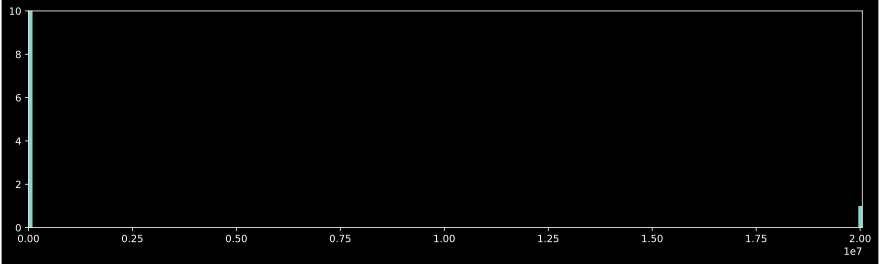

In [119]:
df['HouseYear'].hist(figsize=(15,4),bins=208, grid=False);
plt.axis([0, 20052011, 0, 10]);

<Figure size 720x720 with 0 Axes>

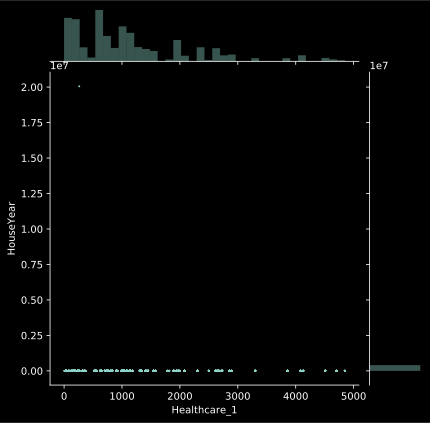

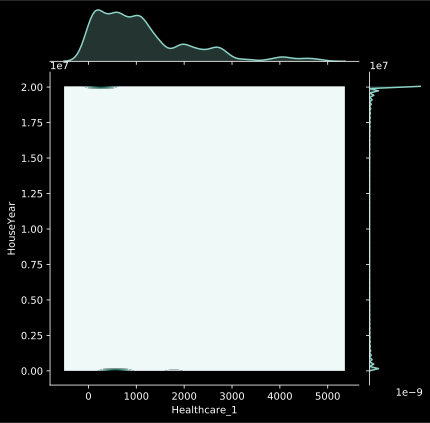

In [113]:
plt.figure(figsize=(10,10))
sns.jointplot(df['Healthcare_1'], df['HouseYear'], s=1);
sns.jointplot(df['Healthcare_1'], df['HouseYear'], kind='kde');

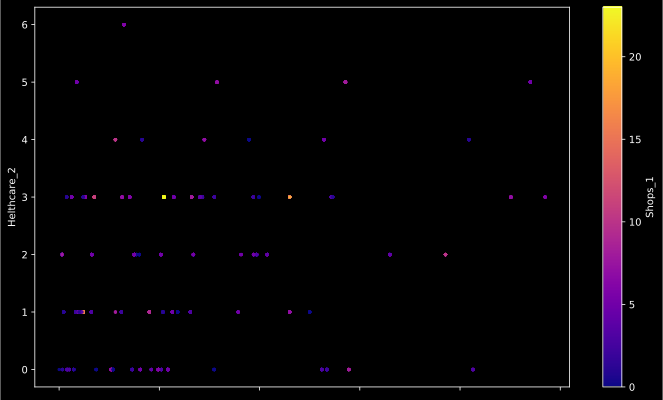

In [104]:
df2.plot(kind='scatter', x='Healthcare_1', y='Helthcare_2', c='Shops_1', s=5, cmap='plasma', figsize=(12, 7));

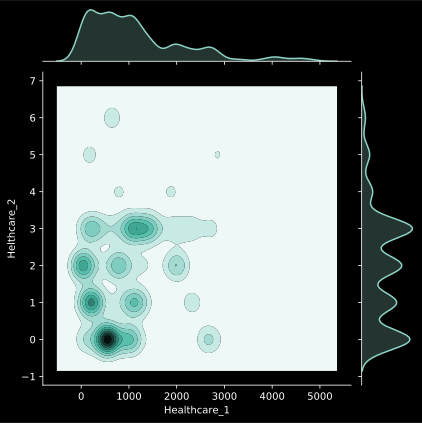

In [108]:
sns.jointplot(df['Healthcare_1'], df['Helthcare_2'], kind='kde');

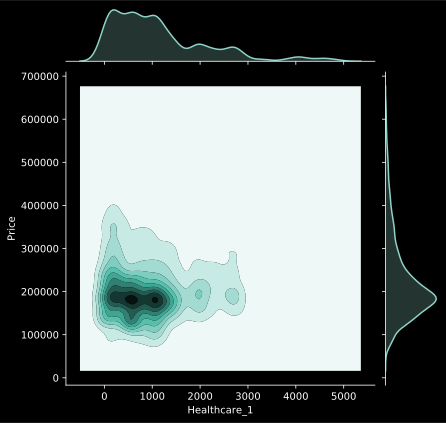

In [89]:
sns.jointplot(df['Healthcare_1'], df['Price'],kind='kde' );

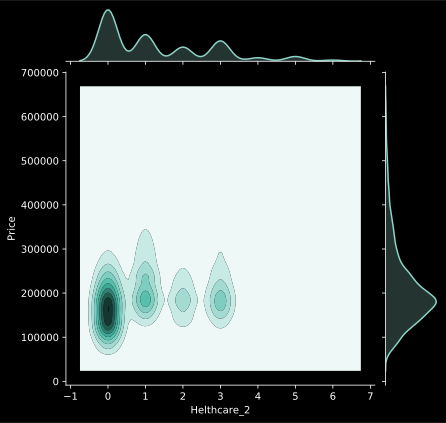

In [91]:
sns.jointplot(df['Helthcare_2'], df['Price'],kind='kde' );

<Figure size 720x720 with 0 Axes>

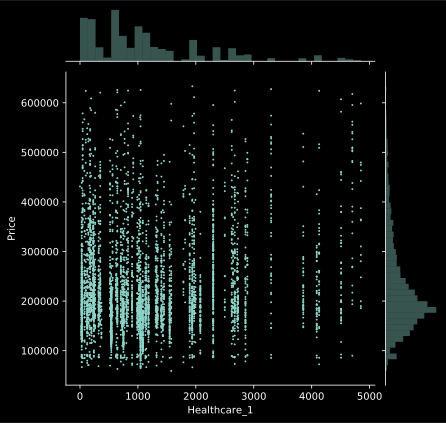

In [86]:
plt.figure(figsize=(10,10));
sns.jointplot(df['Healthcare_1'], df['Price'], s=1);

<Figure size 720x720 with 0 Axes>

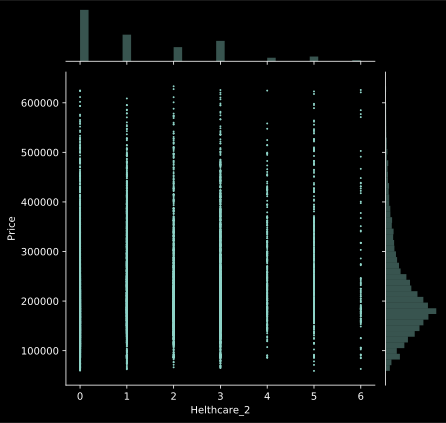

In [87]:
plt.figure(figsize=(10,10));
sns.jointplot(df['Helthcare_2'], df['Price'], s=1);

## Back-up

In [16]:
#df_life_sq_less_10 = df.loc[df['LifeSquare'] < 10]